In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [2]:
from pymongo import MongoClient
connection=MongoClient("mongodb://localhost:27017/crawler.contents")

db=connection.get_database()
articles = pd.DataFrame(list(db.contents.find()))
articles = articles.drop(columns=['visited','alternateImageUrl','created_at','contentType','date','icon','publishedAt','source','url'])


In [3]:
classes = list(set(articles.classes_target.dropna().values.sum()))

In [4]:
df = pd.concat([articles,articles['classes_target'].fillna("").map(lambda x: ",".join(x)).str.get_dummies(sep=",")],axis=1)
counts = []
for i in classes:
    counts.append((i,df[i].sum()))
    
print(counts)


[('EUR', 12751), ('NZD', 2953), ('OIL', 1988), ('BTC', 1096), ('ARS', 17), ('JPY', 6399), ('CNY', 1522), ('TRY', 1069), ('CAD', 2620), ('MXN', 582), ('AUD', 4946), ('USD', 19259), ('INDEX', 10092), ('CHF', 1600), ('GBP', 7172), ('TWD', 72), ('XAU', 1446), ('RUB', 352)]


In [5]:
stats = pd.DataFrame(counts, columns=['cat','count'])

In [6]:
stats

,cat,count
0,EUR,12751
1,NZD,2953
2,OIL,1988
3,BTC,1096
4,ARS,17
5,JPY,6399
6,CNY,1522
7,TRY,1069
8,CAD,2620
9,MXN,582


Text(0.5, 0, 'category')

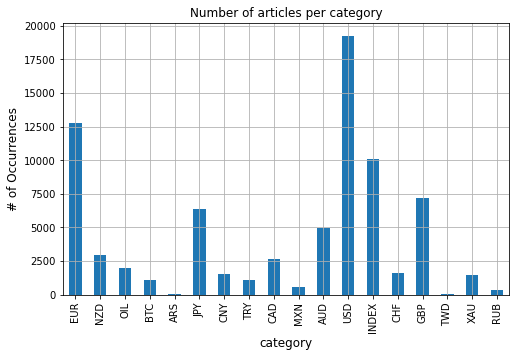

In [7]:
stats.plot(x='cat', y='count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of articles per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

/home/visnja/anaconda3/envs/python3.7-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/home/visnja/anaconda3/envs/python3.7-env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, '# of categories')

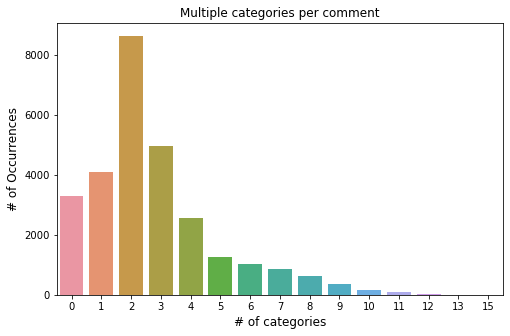

In [8]:
import seaborn as sns
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [9]:
print('Percentage of comments that are not labelled:')
print(len(df[(df['classes_target'].str.len()==0)]) / len(df))

Percentage of comments that are not labelled:
0.09466671442386905


<AxesSubplot:>

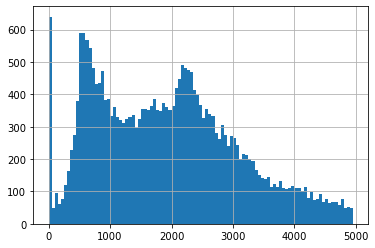

In [10]:
lens = df.body.dropna().map(lambda x: " ".join(x)).str.len()
lens.hist(bins = np.arange(0,5000,50))

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [12]:

to_remove = ['ARS','MXN','OIL','XAU','TRY','INDEX','BTC','TWD','RUB','CHF']
df = df.drop(labels=to_remove,axis=1)
classes = [cls for cls in classes if cls not in to_remove]
df['text_clean'] = df.body.map(lambda x: " ".join(list(x)) if type(x) is list else "" ).map(lambda com : clean_text(com))

                        _id  \
0  623d62126e887c1f5ed1a34e   
1  623d62126e887c1f5ed1a350   
2  623d62126e887c1f5ed1a34c   
3  623d62126e887c1f5ed1a351   
4  623d62126e887c1f5ed1a352   

                                               title  \
0  Risk currencies recover from Friday carnage, d...   
1  Taiwan punishes Deutsche Bank, others in curre...   
2  BoE hikes, Fed pivots, ECB rolls slow as pande...   
3         Dollar extends rebound as U.S. yields rise   
4  Dollar recovery pushes sterling below $1.35; U...   

                                             summary  \
0  The Australian dollar and other riskier curren...   
1  Taiwan's central bank said on Sunday it had ba...   
2  (Reuters) -Britain became the first G7 economy...   
3  The dollar edged higher across the board on Mo...   
4  The pound was among the risk assets hurt by th...   

                                                body  \
0  [By Reuters Staff, 3 MIN READ, TOKYO (Reuters)...   
1  [By Reuters Staff, 3 MIN

In [13]:
df[classes].sum(axis=1)
train, test = train_test_split(df[(df[classes].sum(axis=1)>0)], random_state=42, test_size=0.50, shuffle=True)

In [14]:
# NB_pipeline = Pipeline([
#                 ('tfidf', TfidfVectorizer(stop_words=stop_words)),
#                 ('clf', OneVsRestClassifier(MultinomialNB(
#                     fit_prior=True, class_prior=None))),
#             ])
# for category in categories:
#     print('... Processing {}'.format(category))
#     # train the model using X_dtm & y
#     NB_pipeline.fit(X_train, train[category])
#     # compute the testing accuracy
#     prediction = NB_pipeline.predict(X_test)
#     print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
#     print('Balanced Test accuracy is {}'.format(balanced_accuracy_score(test[category], prediction)))

In [15]:
# LogReg_pipeline = Pipeline([
#                 ('tfidf', TfidfVectorizer(stop_words=stop_words)),
#                 ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
#             ])
# for category in categories:
#     print('... Processing {}'.format(category))
#     # train the model using X_dtm & y
#     LogReg_pipeline.fit(X_train, train[category])
#     # compute the testing accuracy
#     prediction = LogReg_pipeline.predict(X_test)
#     print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

In [16]:
# SVC_pipeline = Pipeline([
#                 ('tfidf', TfidfVectorizer(stop_words=stop_words)),
#                 ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
#             ])
# for category in categories:
#     print('... Processing {}'.format(category))
#     # train the model using X_dtm & y
#     SVC_pipeline.fit(X_train, train[category])
#     # compute the testing accuracy
#     prediction = SVC_pipeline.predict(X_test)
#     print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

In [17]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectorizer.fit(train.text_clean)
vectorizer.fit(test.text_clean)


TfidfVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [18]:
# # using classifier chains
# from skmultilearn.problem_transform import ClassifierChain
# from sklearn.linear_model import LogisticRegression# initialize classifier chains multi-label classifier
# classifier = ClassifierChain(LogisticRegression())# Training logistic regression model on train data
# classifier.fit(x, y)# predict
# predictions = classifier.predict(vectorizer.transform(X_test))# accuracy
# print("Accuracy = ",accuracy_score(test.drop(labels=['_id','summary','body','text_clean','classes_target','classes_body','classes_summary','classes_title','title'],axis=1),predictions))
# print("\n")

In [19]:
n =400
listdf = [train[i:i+n] for i in range(0,train.shape[0],n)]

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())# train
# classifier.fit(x_train, y_train)# predict
# predictions = classifier.predict(x_test)# accuracy
# print("Accuracy = ",accuracy_score(y_test,predictions))

In [20]:
for x in listdf:
    X_train = vectorizer.transform(x.text_clean)
    y_train = x.drop(labels=['_id','summary','body','text_clean','classes_target','classes_body','classes_summary','classes_title','title'],axis=1)
    classifier.fit(X_train,y_train)

In [21]:
listdf = [test[i:i+n] for i in range(0,test.shape[0],n)]
predictions = []
for x in listdf:
    predictions.append(classifier.predict(vectorizer.transform(x.text_clean)))

In [22]:
ee = [item[0].toarray()[0] for sub_list in predictions for item in sub_list]

In [26]:
print(len(train))

11226


In [27]:
print("Accuracy = ",accuracy_score(test[classes].to_numpy(dtype=float),ee))

Accuracy =  0.002939604489577766
